## Семинар 2 "Распознавание рукописных цифр"

ФИО: Находнов Максим Сергеевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers_my import Linear, Sigmoid, NLLLoss, MSE_Loss, NeuralNetwork # Results from Seminar 1
%matplotlib inline
# %load_ext jupyternotify

In [3]:
shuffle_way = True
batch_sz = 16

In [4]:
import sys
import platform
platform

<module 'platform' from '/home/m.nakhodnov/anaconda3/envs/py2.7.14/lib/python2.7/platform.pyc'>

In [5]:
# origin
transform_origin = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_origin = MNIST('.', train=True, download=True, transform=transform_origin)
test_dataset_origin = MNIST('.', train=False, transform=transform_origin)

train_loader_origin = DataLoader(train_dataset_origin, batch_size=batch_sz, shuffle=shuffle_way)
test_loader_origin = DataLoader(test_dataset_origin, batch_size=batch_sz, shuffle=shuffle_way)

Processing...
Done!


In [6]:
# random rotate + crops
rotate_limist = np.array([-15, 15], dtype=np.int64)
crope_scale = (0.7, 1.1)

transform_RC = transforms.Compose([
                       transforms.RandomRotation(degrees=rotate_limist),
                       transforms.RandomResizedCrop(28, scale=crope_scale),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_RC = MNIST('.', train=True, download=True, transform=transform_RC)
test_dataset_RC = MNIST('.', train=False, transform=transform_RC)

train_loader_RC = DataLoader(train_dataset_RC, batch_size=batch_sz, shuffle=shuffle_way)
test_loader_RC = DataLoader(test_dataset_RC, batch_size=batch_sz, shuffle=shuffle_way)

In [7]:
X_RC, y_RC = next(iter(train_loader_RC))
X_RC = X_RC.numpy()
y_RC = y_RC.numpy()

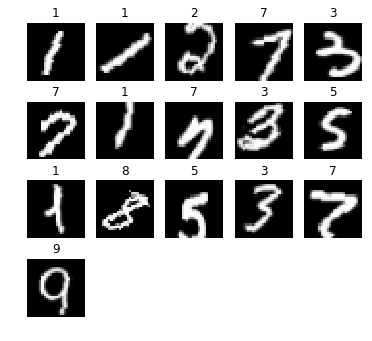

In [8]:
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_RC[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y_RC[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [9]:
def train_hidden(network, train_loader, test_loader, loss_func, epochs, params_func, epoch_bias = 0):
    
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            # Prepare train set
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss_func.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss_func.backward()
                network.backward(dLdx)
                network.step(params_func(epoch + epoch_bias))
                accuracies.append((np.argmax(prediction, 1)==y).mean())
                
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            # Get current loss and accuracy on origin test set
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss_func.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            # Print train and test losses and accuracies
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.4f}/{2:.4f}\tAccuracy: {3:.4f}/{4:.4f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [10]:
class ReLU:
    def __init__(self, silent=True):
        self.silent = silent
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        
        if self.silent == False:
            print('############ ReLU start ############\n')
            print('X', X, '\n')
            print('y', np.maximum(np.zeros(X.shape), X), '\n')
            print('############ ReLU end ############')
        
        self.r = np.maximum(np.zeros(X.shape), X)
        return self.r
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * np.sign(self.r) 
    
    def step(self, learning_rate):
        pass

In [11]:
class ELU:
    def __init__(self, alpha):
        '''
        Set hyper-parameter
        '''
        self.alpha = alpha
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.e = X
        self.e[X < 0] = self.alpha * (np.exp(X[X < 0]) - 1)
        return self.e
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydx = self.e + self.alpha
        dydx[self.e > 0] = 1
        return dLdy * dydx
    
    def step(self, learning_rate):
        pass

In [12]:
silent_way = True

arc_sigm = [Linear(784, 100, None, None, None, silent_way), Sigmoid(),
       Linear(100, 100, None, None, None, silent_way), Sigmoid(),
       Linear(100, 10, None, None, None, silent_way)]

arc_elu = [Linear(784, 100, None, None, None, silent_way), ELU(1),
       Linear(100, 100, None, None, None, silent_way), ELU(1),
       Linear(100, 10, None, None, None, silent_way)]

arc_relu = [Linear(784, 100, None, None, None, silent_way), ReLU(),
       Linear(100, 100, None, None, None, silent_way), ReLU(),
       Linear(100, 10, None, None, None, silent_way)]

network_sigm = NeuralNetwork(arc_sigm)
network_elu = NeuralNetwork(arc_elu)
network_relu = NeuralNetwork(arc_relu)



def params_func_adam(epoch):
    return [0.001, 0.9, 0.999, 10e-8]

def params_func_sigm(epoch):
    if epoch > 5:
        return [0.025]
    if epoch > 10:
        return [0.01]
    if epoch > 15:
        return [0.005]
    if epoch > 20:
        return [0.002]
    return [0.05]
def params_func_elu(epoch):
    if epoch > 5:
        return [0.025]
    if epoch > 10:
        return [0.01]
    if epoch > 15:
        return [0.005]
    if epoch > 20:
        return [0.002]
    return [0.05]
def params_func_relu(epoch):
    if epoch > 5:
        return [0.025]
    if epoch > 10:
        return [0.01]
    if epoch > 15:
        return [0.005]
    if epoch > 20:
        return [0.002]
    return [0.05]

Epoch 6... (Train/Test) NLL: 0.2138/0.1182	Accuracy: 0.9358/0.9666

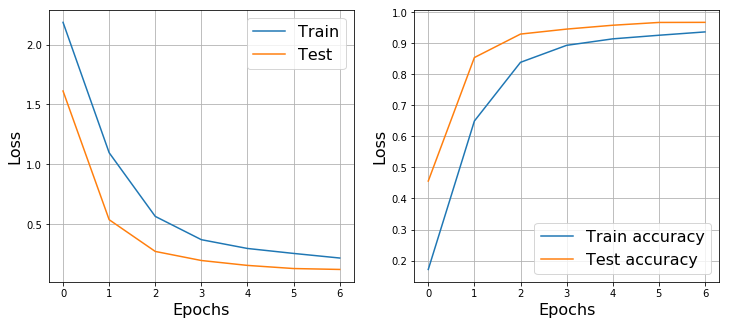

In [14]:
# %%notify -o
train_hidden(network_sigm, train_loader_RC, test_loader_origin, NLLLoss(), 7, params_func_sigm)

Epoch 12... (Train/Test) NLL: 0.1506/0.0777	Accuracy: 0.9534/0.9762

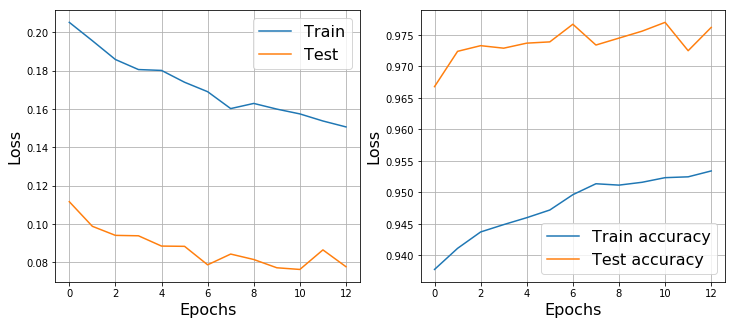

In [15]:
# %%notify -o
train_hidden(network_sigm, train_loader_RC, test_loader_origin, NLLLoss(), 13, params_func_sigm, 7)

Epoch 6... (Train/Test) NLL: 0.1109/0.0562	Accuracy: 0.9661/0.9813

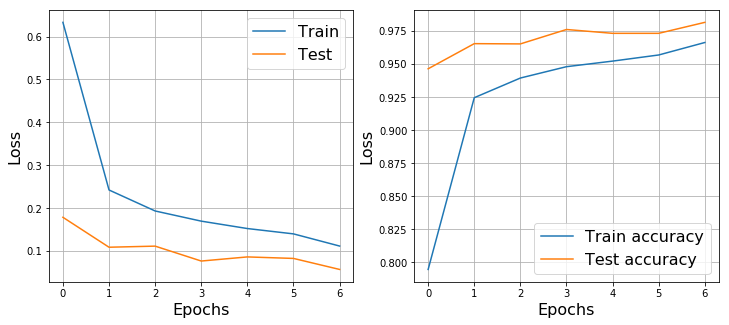

In [16]:
# %%notify -o
train_hidden(network_elu, train_loader_RC, test_loader_origin, NLLLoss(), 7, params_func_elu)

Epoch 12... (Train/Test) NLL: 0.0848/0.0497	Accuracy: 0.9737/0.9841

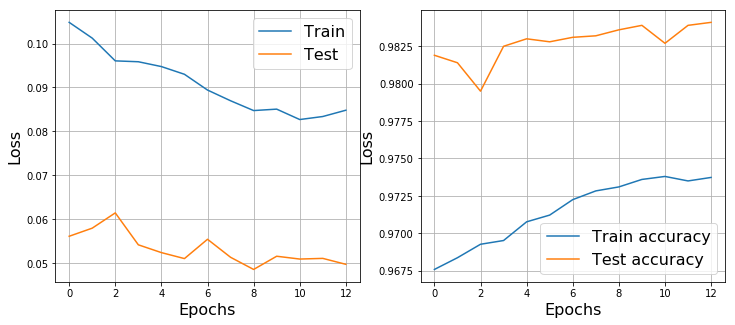

In [18]:
# %%notify -o
train_hidden(network_elu, train_loader_RC, test_loader_origin, NLLLoss(), 13, params_func_elu, 7)

Epoch 6... (Train/Test) NLL: 0.1175/0.0574	Accuracy: 0.9628/0.9809

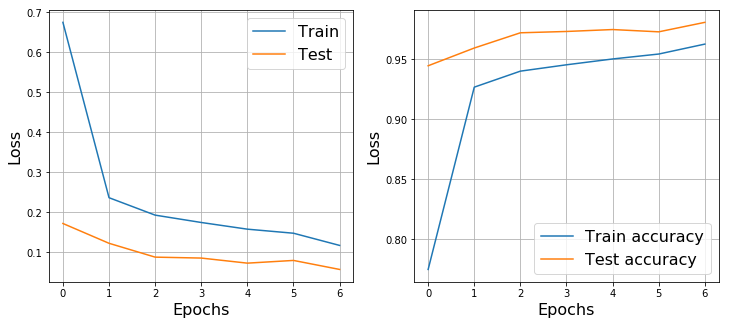

In [19]:
# %%notify -o
train_hidden(network_relu, train_loader_RC, test_loader_origin, NLLLoss(), 7, params_func_relu)

Epoch 12... (Train/Test) NLL: 0.0861/0.0525	Accuracy: 0.9732/0.9825

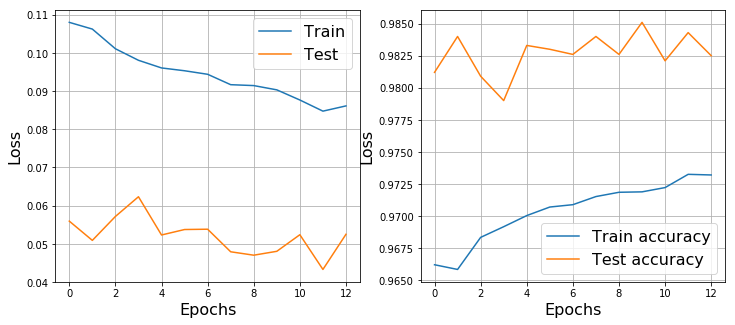

In [20]:
# %%notify -o
train_hidden(network_relu, train_loader_RC, test_loader_origin, NLLLoss(), 13, params_func_relu, 7)

In [21]:
arc_elu_no_aug = [Linear(784, 100, None, None, None, silent_way), ELU(1),
       Linear(100, 100, None, None, None, silent_way), ELU(1),
       Linear(100, 10, None, None, None, silent_way)]

network_elu_no_aug = NeuralNetwork(arc_elu_no_aug)

Epoch 6... (Train/Test) NLL: 0.0176/0.0694	Accuracy: 0.9946/0.9811

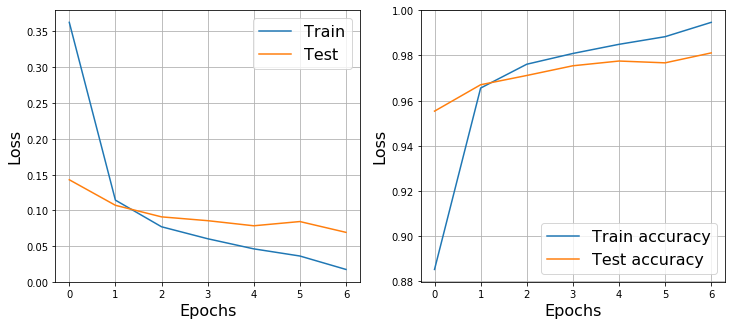

In [22]:
# %%notify -o
train_hidden(network_elu_no_aug, train_loader_origin, test_loader_origin, NLLLoss(), 7, params_func_elu)

Epoch 12... (Train/Test) NLL: 0.0009/0.0881	Accuracy: 1.0000/0.9817

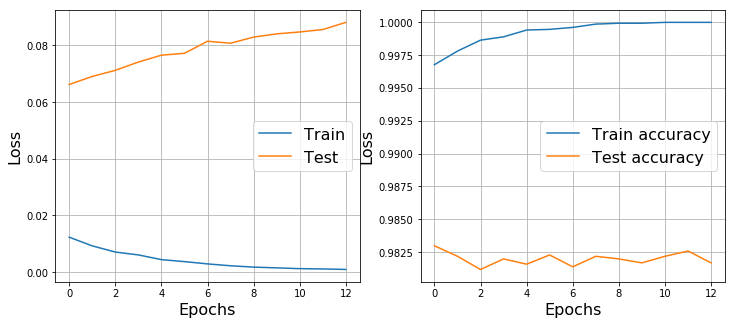

In [23]:
# %%notify -o
train_hidden(network_elu_no_aug, train_loader_origin, test_loader_origin, NLLLoss(), 13, params_func_elu, 7)

### Часть 3: Анализ ошибок

In [24]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader_origin:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network_elu.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

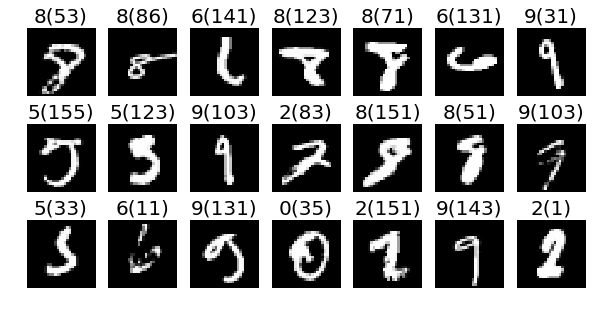

In [25]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Сравнивая различные функции активации получаем следующий итог:

* ELU - лучшая как по скорости сходимости (у неё найлучший результат спустя 7 эпох), так и по достигнутому результату (более 98.5% после 20 эпох).
* ReLU - вторая
* Sigmoida - худший результат (за 7 эпох точность меньше 97%, за 20 эпох сеть сходится, но не достигает точности даже 98%)

При этом сравнивая ELU с использованием аугментации (случайные повороты + случайный кроп) и без получаем:
* Без использования аугментации точность на train очень быстро становится больше 99.9%, с использованием аугментации такого не происходит - т.е. сеть не переобучается
* Использование аугментации даёт увеличение итоговой точности примерно на 0.5%